In [3]:
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric import datasets

import numpy as np
import random

import matplotlib.pyplot as plt
from utils.graph_polluters import remove_edges, remove_features

##from modules.heteroGNN import HeteroGNN
#import graph_polluters
from tqdm import tqdm

# We initialize conference node features with a single one-vector as feature:
dataset = dataset = datasets.DBLP('./data/dblp', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)


def set_seed(seed=42):
    #torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    #torch.use_deterministic_algorithms(True)
    np.random.seed(seed)
    torch.manual_seed(seed) 
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


/home/iailab42/kanea0/my-env/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(

# Model
Here we define our model and Training Loop

In [4]:
from modules.heteroGNN import HeteroGNN

# %%
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def init_parameters(data):
    model = HeteroGNN(data.metadata(), hidden_channels=10, out_channels=4, num_layers=2, target_node_type='author')
    #model = HGT(hidden_channels=64, out_channels=4, num_heads=2, num_layers=3, data=data)
    data, model = data.to(device), model.to(device)
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    return model, optimizer

# %%
def train(data, model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data, model):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

# Tests
We see how the model copes with the various pollution in the graph

## Baseline

In [5]:
set_seed()
dataset_copy = dataset.copy()
data_copy = dataset_copy[0]
data_copy.to(device)
model, optimizer = init_parameters(data_copy)
train_accs, val_accs, test_accs = [],[],[]
for epoch in range(5000):
    loss = train(data=data_copy, model=model, optimizer=optimizer)
    train_acc, val_acc, test_acc = test(data = data_copy, model=model)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
print(f'Baseline: Best Epoch: {best_epoch} Train: {train_acc:.4f}, '
        f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Baseline: Best Epoch: 3593 Train: 1.0000, Val: 0.8175, Test: 0.8219


## Remove Features

50% dirty, Train: 1.0000, Val: 0.7300, Test: 0.7353


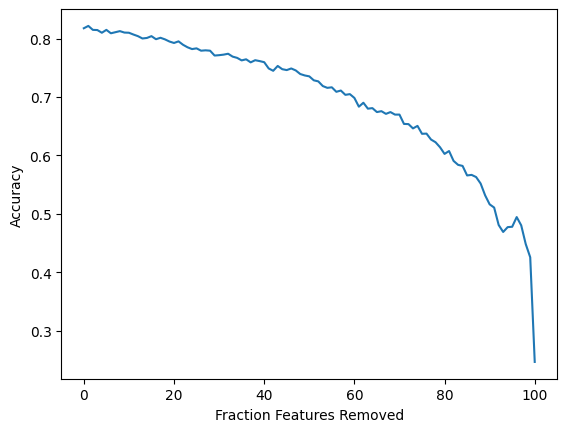

In [ ]:
print_precentages = [50]

test_acc_hist = []
for percent in range(101):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    remove_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(101), test_acc_hist)
plt.ylabel('Accuracy')
plt.xlabel('% Features Removed')
plt.show()

50% dirty, Train: 1.0000, Val: 0.7525, Test: 0.7467


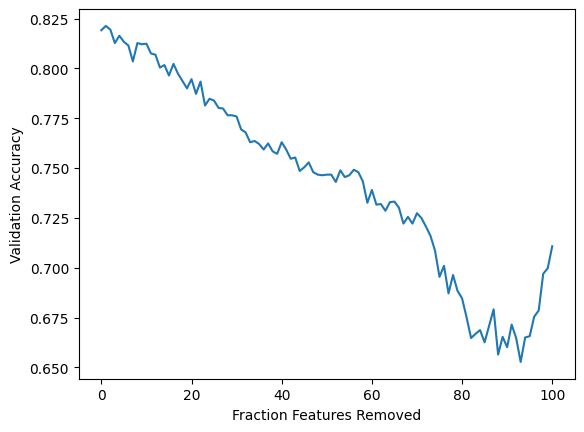

In [9]:
print_precentages = [50]

test_acc_hist = []
for percent in range(101):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    remove_features(data=data_copy, probability=pollution_probability, node_types=['author', 'paper'])
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(101), test_acc_hist)
plt.ylabel('Accuracy')
plt.xlabel('Fraction Features Removed')
plt.show()

## Randomize Features

In [7]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    randomize_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Randomized')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'randomize_features' is not defined

In [1]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    graph_polluters.randomize_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Randomized')
plt.show()

NameError: name 'tqdm' is not defined

## Remove Edges

In [11]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    data_copy = remove_edges(data_copy, pollution_probability)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Accuracy')
plt.xlabel('% Edges Removed')
plt.show()

 16%|█▌        | 16/100 [01:03<05:18,  3.79s/it]

 51%|█████     | 51/100 [03:15<02:34,  3.15s/it]

50% dirty, Train: 0.9250, Val: 0.5750, Test: 0.6027


100%|██████████| 100/100 [05:09<00:00,  3.09s/it]


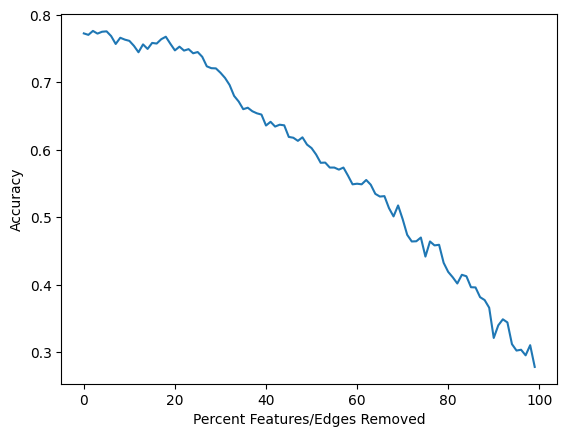

In [7]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    data_copy = remove_edges(data_copy, pollution_probability)
    remove_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Accuracy')
plt.xlabel('% Features/Edges Removed')
plt.show()

In [2]:
a = torch.as_tensor([1,1,3,3,1,2])

In [3]:
import torch_geometric.utils


torch_geometric.utils.degree(a)

tensor([0., 3., 1., 2.])

In [4]:
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [8]:
torch_geometric.utils.degree(data[('author', 'to', 'paper')].edge_index[0])

tensor([ 2., 10.,  3.,  ...,  1.,  1.,  1.])

In [10]:
data.node_types

['author', 'paper', 'term', 'conference']

In [26]:
import torch.nn.functional as F

def get_degrees_one_hot(data):
    degrees = {}
    for node_type in data.node_types:
        degrees[node_type] = torch.zeros(data[node_type].x.shape[0])

    for edge_type, edge_storage in data.edge_items():
        out_node_type = edge_type[0]
        edge_index = edge_storage['edge_index']
        a = degrees[out_node_type]
        degrees[out_node_type] += torch_geometric.utils.degree(edge_index[0], num_nodes=degrees[out_node_type].shape[0])

    encodings = {}
    for node_type in data.node_types:
        encoded = F.one_hot(degrees[node_type].to(torch.int64))
        non_empty_mask = encoded.abs().sum(dim=0).bool()
        encodings[node_type] = encoded[:,non_empty_mask]

    return encodings

In [27]:
degrees

{'author': tensor([ 2., 10.,  3.,  ...,  1.,  1.,  1.]),
 'paper': tensor([ 7.,  9.,  9.,  ...,  8.,  7., 14.]),
 'term': tensor([204.,  65.,  23.,  ...,   1.,   1.,   1.]),
 'conference': tensor([1592.,  721.,  225.,  204.,  192.,  300., 1423.,  525.,  632., 1814.,
          795.,  367.,  287.,  456.,  244., 1374., 1353., 1471.,  342.,   11.])}

In [3]:
import torch


In [5]:
buckets = torch.tensor([1,2,3,5,10] + list(range(20,50+1,10)))

In [6]:
thing = torch.tensor([0,5,1,50,60,49,31])

In [ ]:
torch.bucketize(thing,buckets)

In [2]:
import torch

In [5]:
a = torch.as_tensor([1,2,3,4])

In [6]:
a = a * torch.eye(4)

tensor([[1., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 4.]])

In [10]:
b

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1892, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.3161, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.4142]])

In [45]:
edge_index=torch.as_tensor([[0,0,1,2,3,4,1,3,2,3,4,0],[1,3,2,3,4,0,0,0,1,2,3,4]])

In [35]:
edge_index

tensor([[0., 0., 1., 2., 3., 4., 1., 3., 2., 3., 4., 0.],
        [1., 3., 2., 3., 4., 0., 0., 0., 1., 2., 3., 4.]], dtype=torch.float64)

In [3]:
from torch_geometric import utils

In [33]:
a = utils.degree(edge_index[0])
a = a * torch.eye(a.shape[0])
b = a.pow_(-0.5)
b = b.masked_fill_(b==float("inf"),0)

RuntimeError: scatter(): Expected dtype int64 for index

In [27]:
b = b.

tensor([[0.5774, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7071, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5774, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.7071]])

In [16]:
edge_index_d = utils.to_dense_adj(edge_index)

In [47]:
a_norm = b @ edge_index_d @ b

In [48]:
a_norm

tensor([[[0.0000, 0.4082, 0.0000, 0.3333, 0.4082],
         [0.4082, 0.0000, 0.5000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000, 0.4082, 0.0000],
         [0.3333, 0.0000, 0.4082, 0.0000, 0.4082],
         [0.4082, 0.0000, 0.0000, 0.4082, 0.0000]]])

In [18]:
import torch.sparse

In [42]:
features = torch.ones(5,4)

In [43]:
a_norm @ features

tensor([[[1.1498, 1.1498, 1.1498, 1.1498],
         [0.9082, 0.9082, 0.9082, 0.9082],
         [0.9082, 0.9082, 0.9082, 0.9082],
         [1.1498, 1.1498, 1.1498, 1.1498],
         [0.8165, 0.8165, 0.8165, 0.8165]]])

In [46]:
from enhancements.feature_prop_2 import get_symmetrically_normalized_adjacency
get_symmetrically_normalized_adjacency(edge_index,5)

(tensor([[0, 0, 1, 2, 3, 4, 1, 3, 2, 3, 4, 0],
         [1, 3, 2, 3, 4, 0, 0, 0, 1, 2, 3, 4]]),
 tensor([0.4082, 0.3333, 0.5000, 0.4082, 0.4082, 0.4082, 0.4082, 0.3333, 0.5000,
         0.4082, 0.4082, 0.4082]))

In [12]:
ei_0 = utils.to_torch_sparse_tensor(data[('author', 'to', 'paper')].edge_index, size=(4057, 14328))
ei_1 = utils.to_torch_sparse_tensor(data[('paper', 'to', 'author')].edge_index, size=(14328, 4057))

In [13]:
ei_0

tensor(indices=tensor([[    0,     0,     1,  ...,  4054,  4055,  4056],
                       [ 2364,  6457,  2365,  ..., 13891, 13891, 13892]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(4057, 14328), nnz=19645, layout=torch.sparse_coo)

In [14]:
torch.sparse.mm(ei_0, ei_1)

/tmp/ipykernel_206983/3918296752.py:1: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  torch.sparse.mm(ei_0, ei_1)


tensor(indices=tensor([[   0,    1,    1,  ..., 4055, 4056, 4056],
                       [   0,    1,    5,  ..., 4055, 1396, 4056]]),
       values=tensor([ 2., 10.,  1.,  ...,  1.,  1.,  1.]),
       size=(4057, 4057), nnz=11113, layout=torch.sparse_coo)

In [7]:
from torch_geometric import utils
import torch
edge_index = torch.as_tensor([[4,1,2,3,0,2,1],[0,0,0,0,1,1,2]])

_, a, _, _ = utils.k_hop_subgraph(0, 1, edge_index, directed=True, flow='source_to_target')

In [13]:
edge_index.shape

torch.Size([2, 7])

In [14]:
edge_index[1]

tensor([0, 0, 0, 0, 1, 1, 2])

In [49]:
a = torch.as_tensor([[1.],[99.]])
b = torch.as_tensor([[1.,2.,3.],[1.,1.,1.]])

In [50]:
a.shape

torch.Size([2, 1])

In [42]:
c = torch.zeros_like(b)

In [51]:
torch.cat([b,a], dim=1)

tensor([[ 1.,  2.,  3.,  1.],
        [ 1.,  1.,  1., 99.]])

In [31]:
torch.cosine_similarity(a,b,dim=1)[0].item()

0.9999998807907104

In [34]:
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [35]:
data[('author','to','paper')].ap

{'edge_index': tensor([[    0,     0,     1,  ...,  4054,  4055,  4056],
        [ 2364,  6457,  2365,  ..., 13891, 13891, 13892]])}